# 유한 오토마타 Haskell로 작성해보기

책 110p 예제

In [1]:
type NFA = (Int, [(Int,String,Int)], [Int])
{- (max state, transitaions, final states)

assume start state is 0
-}

In [2]:
import IHaskell.Display.Graphviz
import Data.List

toDot :: NFA -> String
toDot (n, ds, fs) =
    "digraph { rankdir=LR; node [shape=circle]; start [shape=none] ; start -> 0; "
  ++ concat [show f++" [shape=doublecircle]; " | f<-fs ]
  ++ concatMap showLabels ds
  ++"}"
  where
  -- pqss = groupBy (\(p,_,q) (p',_,q') -> p==p' && q==q') ds
  -- pqs = [(p,as,q)| pqs<-pqss, let (p,_,q)=head pqs, let (_,as,_)=unzip3 pqs]
  showLabels (p,"",q) = show p++" -> "++show q++"[label=\"𝜀\",style=dotted]"
  showLabels (p, a,q) = show p++" -> "++show q++"[label=\""++a++"\"]"
  fillEpsilon "" = "𝜀"
  fillEpsilon s  = s

unwordsBy s = concat . intersperse s

In [3]:
data RE = Nul
        | Eps
        | A Char
        | RE :+ RE
        | RE :. RE
        | Star RE
        deriving Show

infixr 6 :+
infixr 7 :.

In [4]:
e = Eps
a = A 'a'
b = A 'b'

In [5]:
mapNFA :: (Int -> Int) -> NFA -> NFA
mapNFA f (m,ds,fs) = (f m, [(f p,a,f q) | (p,a,q)<-ds], map f fs)

re2nfa :: RE -> NFA
re2nfa Nul   = (0, [], [])
re2nfa Eps   = (0, [], [0])
re2nfa (A a) = (1, [(0,a:[],1)], [1])
re2nfa (r1 :+ r2) = (m, es++ds1++ds2, [m])
  where
  m = m1 + m2 + 3
  nfa1@(m1,_,_) = re2nfa r1
  nfa2@(m2,_,_) = re2nfa r2
  (_,ds1,fs1) = mapNFA (+1)      nfa1
  (_,ds2,fs2) = mapNFA (+(m1+2)) nfa2
  es = (0,"",1) : (0,"",m1+2) : [(f,"",m)| f<-fs1++fs2]
re2nfa (r1 :. r2) = (m, es++ds1++ds2, fs2)
  where
  nfa1@(m1,ds1,fs1) = re2nfa r1
  nfa2@(m2,_,_)     = re2nfa r2
  (m,ds2,fs2) = mapNFA (+(m1+1)) nfa2
  es = [(p,"",m1+1) | p<-fs1]
re2nfa (Star r) = (m+1, es++ds, [m+1])
  where
  (m,ds,fs) = mapNFA (+1) $ re2nfa r
  es = (0,"",m+1) : (m+1,"",0) : (0,"",1) : [(f,"",m+1) | f<-fs]

(0,[],[])

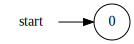

In [6]:
re2nfa Nul
dot . toDot $ re2nfa Nul

(0,[],[0])

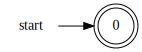

In [7]:
re2nfa Eps
dot . toDot $ re2nfa Eps

(1,[(0,"a",1)],[1])

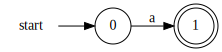

In [8]:
re2nfa a
dot . toDot $ re2nfa a

(5,[(0,"",1),(0,"",3),(2,"",5),(4,"",5),(1,"a",2),(3,"b",4)],[5])

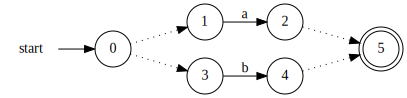

In [9]:
re2nfa $ a :+ b
dot . toDot . re2nfa $ a :+ b

(3,[(1,"",2),(0,"a",1),(2,"b",3)],[3])

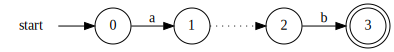

In [10]:
re2nfa $ a :. b
dot . toDot . re2nfa $ a :. b

(3,[(0,"",3),(3,"",0),(0,"",1),(2,"",3),(1,"a",2)],[3])

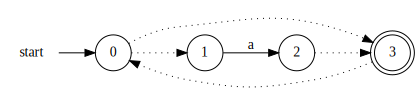

In [11]:
re2nfa $ Star a
dot . toDot . re2nfa $ Star a

(7,[(0,"",7),(7,"",0),(0,"",1),(6,"",7),(1,"",2),(1,"",4),(3,"",6),(5,"",6),(2,"a",3),(4,"b",5)],[7])

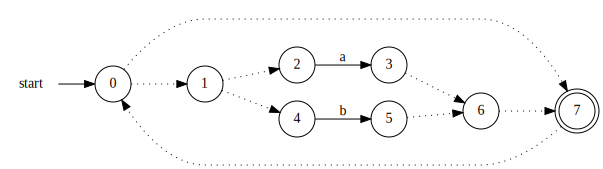

In [12]:
re2nfa $ Star (a :+ b)
dot . toDot . re2nfa $ Star (a :+ b)

(13,[(7,"",8),(0,"",7),(7,"",0),(0,"",1),(6,"",7),(1,"",2),(1,"",4),(3,"",6),(5,"",6),(2,"a",3),(4,"b",5),(9,"",10),(8,"a",9),(11,"",12),(10,"b",11),(12,"b",13)],[13])

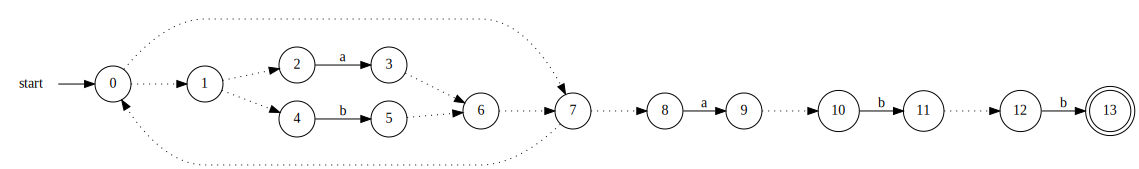

In [13]:
re2nfa $ Star (a :+ b) :. a :. b :. b
dot . toDot . re2nfa $  Star (a :+ b) :. a :. b :. b

In [44]:
step :: NFA -> Int -> String -> [Int]
step (_,ds,_) p a = [q | (p',a',q)<-ds, p==p', a==a']

eStep :: NFA -> Int -> [Int]
eStep nfa p = step nfa p ""

eClosure :: NFA -> [Int] -> [Int]

eClosure nfa ps | ps == ps' = ps'
                | otherwise = eClosure nfa ps'
  where
  ps' = sort . nub $ concatMap (eStep nfa) ps `union` ps

In [45]:
nfa1 = re2nfa $ Star (a :+ b) :. a :. b :. b

In [46]:
eClosure nfa1 [0]

[0,1,2,4,7,8]

In [47]:
eClosure nfa1 [1]

[1,2,4]

In [48]:
eClosure nfa1 [3]

[0,1,2,3,4,6,7,8]

In [49]:
eClosure nfa1 [9]

[9,10]

In [50]:
eClosure nfa1 [0,9]

[0,1,2,4,7,8,9,10]

In [51]:
eClosure nfa1 [5,11]

[0,1,2,4,5,6,7,8,11,12]

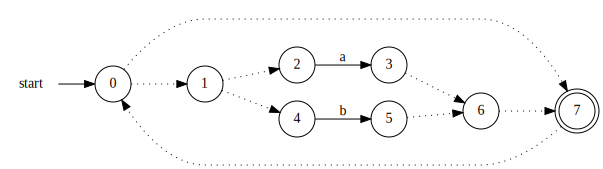

In [65]:
nfa2 = re2nfa $ Star (a :+ b)
dot $ toDot nfa2

In [66]:
eClosure nfa2 [0]
eClosure nfa2 [3]

[0,1,2,4,7]

[0,1,2,3,4,6,7]

In [67]:
deEpsilon :: NFA -> NFA
deEpsilon nfa@(m,ds,fs) = (m,ds',fs)
  where
  as = [ a | d@(_,a,_)<-ds, a/="" ]
  ds' = nub $ do p <- [0..m]
                 a <- as
                 p' <- eClosure nfa [p]
                 q <- step nfa p' a
                 q' <- eClosure nfa [q]
                 return (p,a,q')

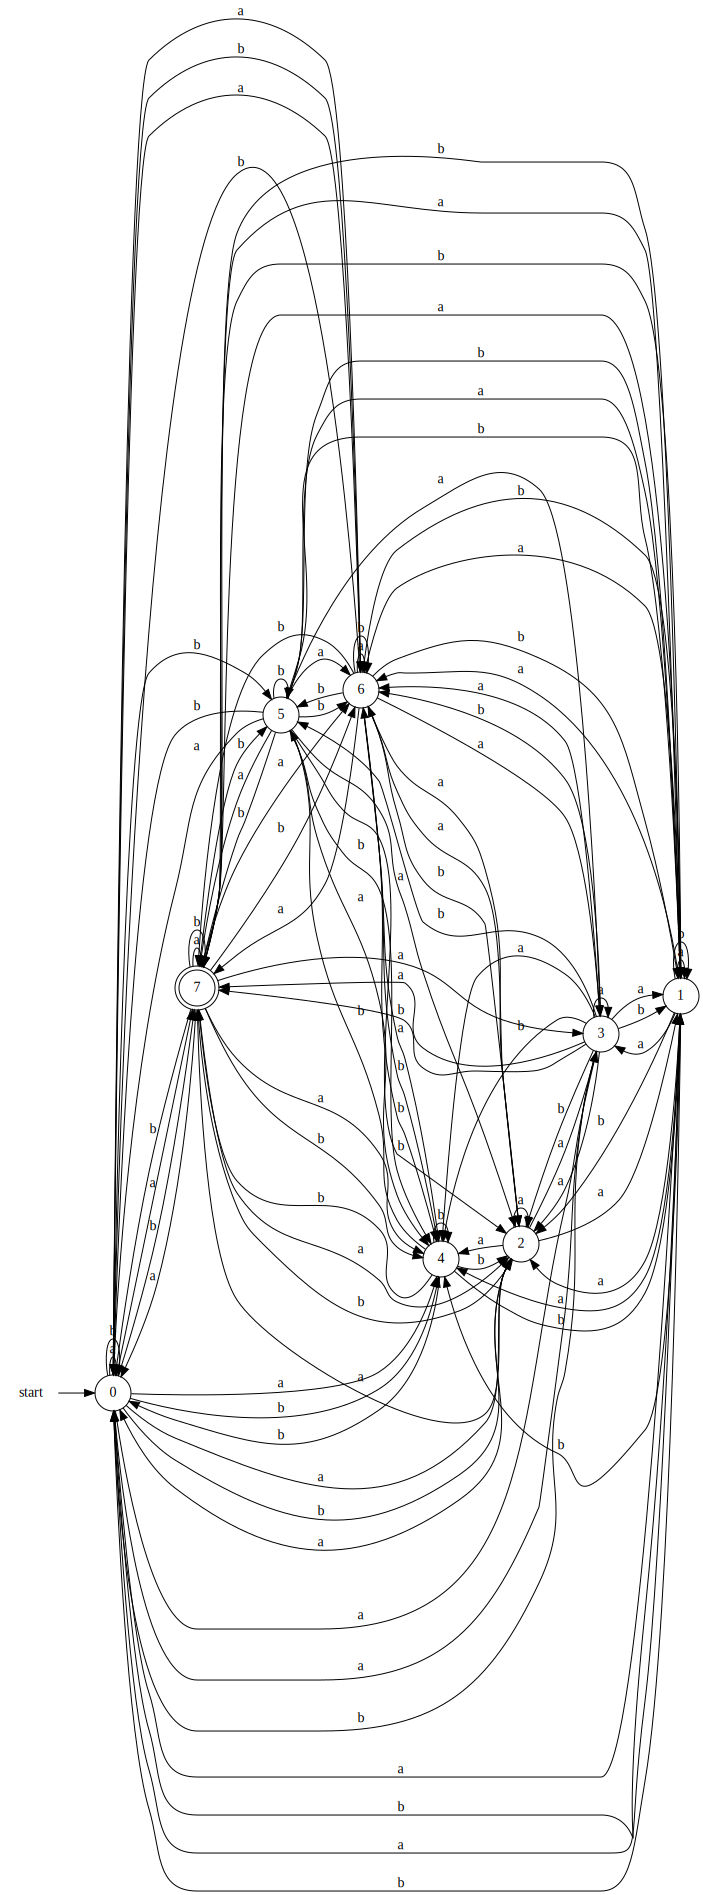

In [68]:
nfa2' = deEpsilon nfa2
dot $ toDot nfa2'

In [71]:
toDot' :: NFA -> String
toDot' (n, ds, fs) =
    "digraph { rankdir=LR; node [shape=circle]; start [shape=none] ; start -> 0; "
  ++ concat [show f++" [shape=doublecircle]; " | f<-fs ]
  ++ concatMap showLabels pqs
  ++"}"
  where
  pqss = groupBy (\(p,_,q) (p',_,q') -> p==p' && q==q') ds
  pqs = [(p,as,q)| pqs<-pqss, let (p,_,q)=head pqs, let (_,as,_)=unzip3 pqs]
  showLabels (p,as,q) = show p++" -> "++show q++"[label=\""++concat(intersperse "," as)++"\"]"
  fillEpsilon "" = "𝜀"
  fillEpsilon s  = s

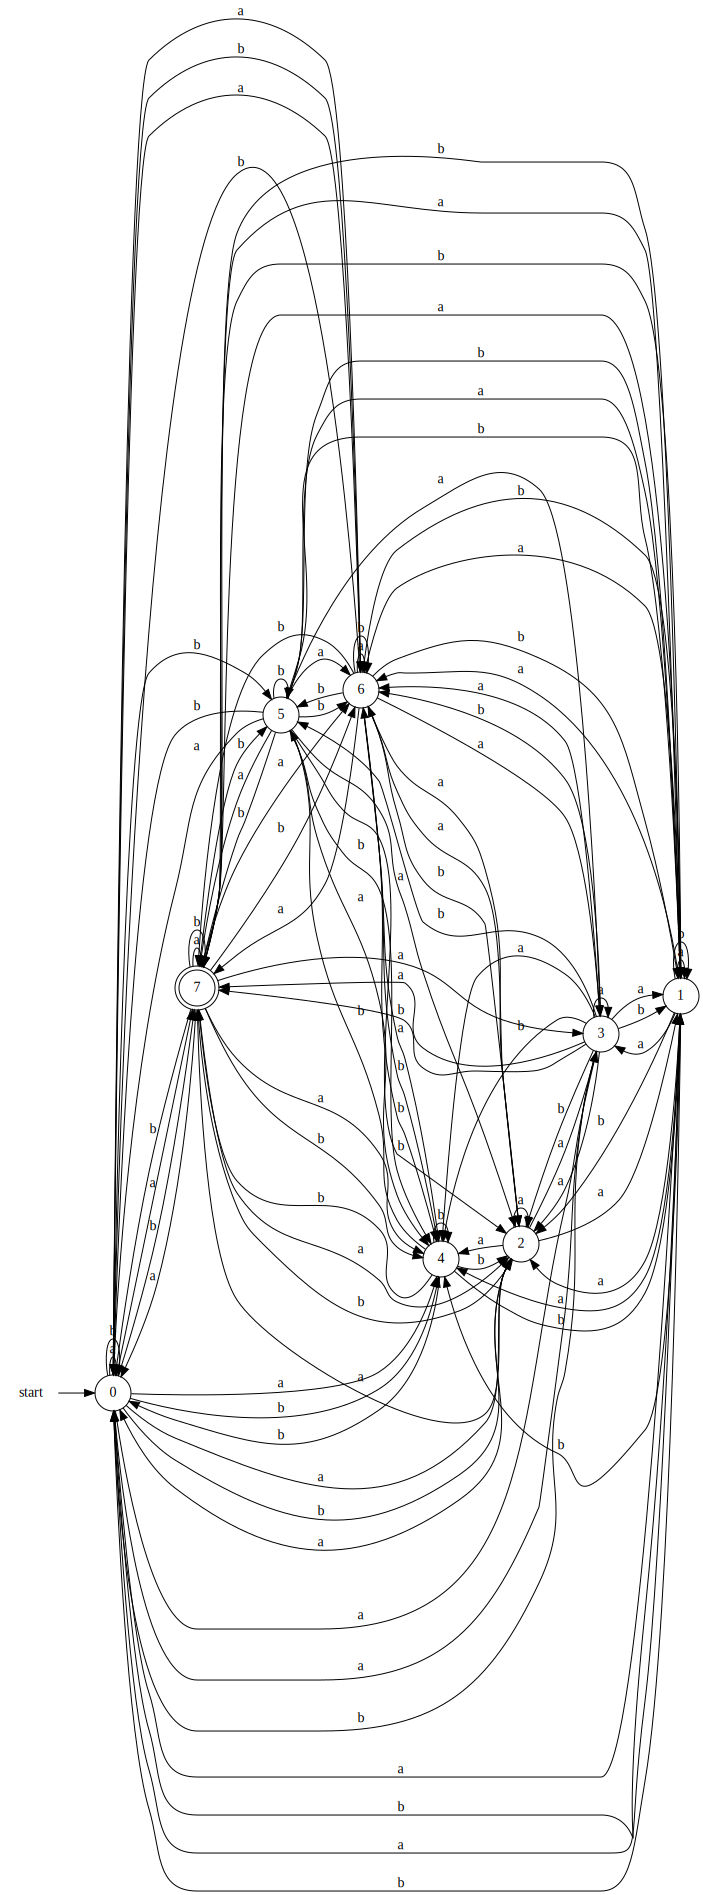

In [72]:
dot $ toDot nfa2'